Using TensorFlow backend.


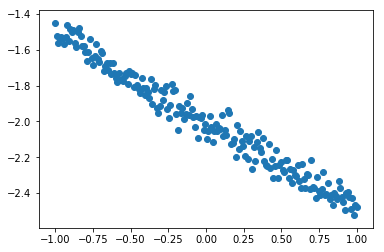

('W1 : ', array([[ 0.55520886]], dtype=float32), 0)
('W1 : ', array([[ 0.33480951]], dtype=float32), 100)
('W1 : ', array([[ 0.2813186]], dtype=float32), 200)
('W1 : ', array([[ 0.27574414]], dtype=float32), 300)
('W1 : ', array([[ 0.27515709]], dtype=float32), 400)
('W1 : ', array([[ 0.27509513]], dtype=float32), 500)
('W1 : ', array([[ 0.27508837]], dtype=float32), 600)
('W1 : ', array([[ 0.27508825]], dtype=float32), 700)
('W1 : ', array([[ 0.27508825]], dtype=float32), 800)
('W1 : ', array([[ 0.27508825]], dtype=float32), 900)


In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import matplotlib.pyplot as plt

# layers
class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dout
    
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None        
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)
        return dx
    
# create data
X = np.linspace(-1, 1, 200)
np.random.shuffle(X)    # randomize the data
Y = -(0.5 * X + 2 + np.random.normal(0, 0.05, (200, )))

# plot data
plt.scatter(X, Y)
plt.show()

X_train, Y_train = X[:160], Y[:160]     # first 160 data points
X_test, Y_test = X[160:], Y[160:]       # last 40 data points

# build a neural network from the 1st layer to the last layer
model = Sequential()

# relu expertment
model.add(Dense(units=1, activation='relu', input_dim=1)) 
model.add(Dense(units=1)) 

# choose loss function and optimizing method
model.compile(loss='mse', optimizer=SGD(lr=0.01))

#model.fit(X_train, Y_train, batch_size = 10, epochs = 20)

#'''
# fit model by loop
for i in range(1000):
    model.train_on_batch(X_train, Y_train)
    W1, b1 = model.layers[0].get_weights()
    W2, b1 = model.layers[0].get_weights()
    if i % 100 == 0:
        print('W1 : ', W1, i) # W1 shoud be 0.27508825    
    if i == 998:        
        lastTwoW1 = W1
        lastTwoW2 = W2
    if i == 999:        
        lastOneW1 = W1
        lastOneW2 = W2
#'''

In [2]:
W1, b1 = model.layers[0].get_weights()
W2, b2 = model.layers[1].get_weights()
affine1 = Affine(W1, b1)
relu = ReLU()
affine2 = Affine(W2, b2)

# forwoard
affine_f1 = affine1.forward(X_train)
relu_f = relu.forward(affine_f1)
affine_f2 = affine2.forward(relu_f)

Y_train = Y_train.reshape(160, 1)
print('mes: ', np.mean((affine_f2 - Y_train)**2)) #loss shoud be 0.0027

# backwoard
dy = 0.5 * (Y_train - affine_f2) # dL/dw = 1/2*(y-yhat)
affine_b2 = affine2.backward(dy)
relu_b = relu.backward(affine_b2)
affine_b1 = affine1.backward(relu_b)

('mes: ', 0.0026214294813137482)


In [3]:
affine1.dW # almost equal 0

array([[ -5.98517423e-05]])

In [4]:
#https://github.com/fchollet/keras/issues/2226
#dE/dW = (w[i] - w[i+1])/learning_rate

(lastOneW1 - lastTwoW1) / 0.01 # verify dW result

array([[ 0.]], dtype=float32)